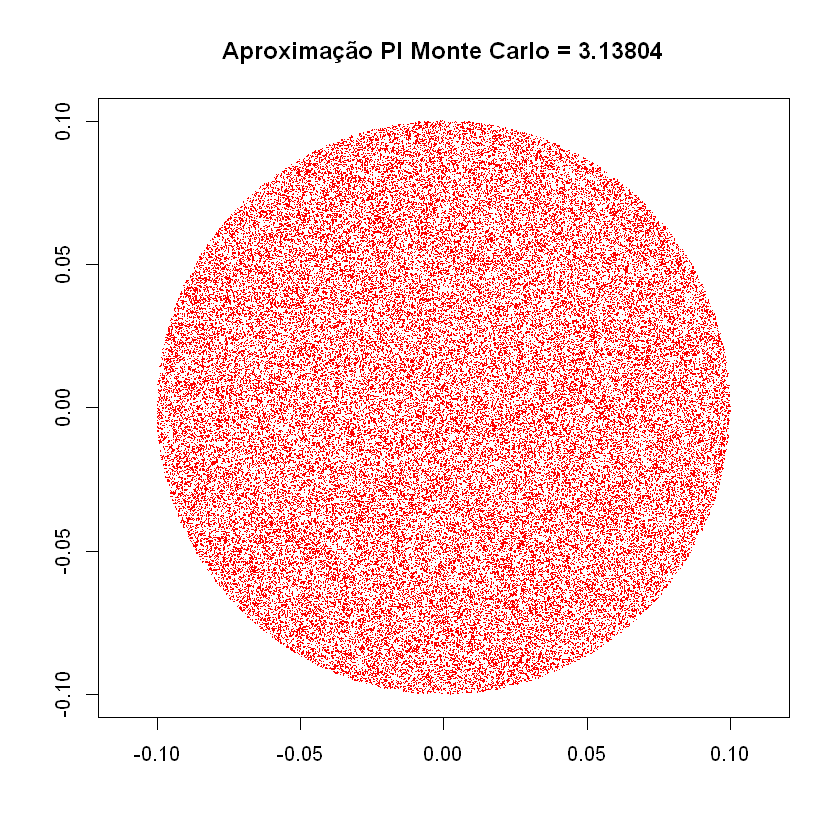

In [4]:
#Simulação de PI
sim_pi <- function(n_sim, minimo, maximo){
  if(minimo >= 0){
    stop(message("Minimum value must be lower than 0"))
  }
  if(!is.integer(n_sim)){
    stop(message("Number of simulations must be integer"))
  }
  if(maximo != -minimo){
    stop("Maximum value must be the opposite of the minimum value")
  }
  x <- runif(n_sim, minimo, maximo)
  y <- runif(n_sim, minimo, maximo)
  dentro_circulo <- x^2 + y^2 <= maximo^2
  pi_monte_carlo <- (sum(dentro_circulo)/n_sim)*4
  plot(x,y,pch='.',col=ifelse(dentro_circulo,"red","white")
       ,xlab='', ylab='',asp=1,
       main=paste("Aproximação PI Monte Carlo =", pi_monte_carlo))
}
sim_pi(n_sim = 100000L, minimo = -0.1, maximo = 0.1)

In [76]:
options(warn = -1)
library(stats)
library(ggplot2)
library(dplyr)
library(tidyr)

In [111]:
#Retorno esperado, desvio-padrão e período de 1 ano útil
u <- 0.228418749759363
sd <- 0.140691431084742
periodo <- 1:252

In [112]:
#Dados da simulação
n_sim <- 4000
total_sim <- matrix(0, nrow = length(periodo), ncol = n_sim)
p_inicial <- 100

In [113]:
for(j in 1:n_sim){
    aux <- 2
    p <- p_inicial
    preco <- c(p)
    dist <- rnorm((length(periodo)-1), 0, 1)
    for(i in dist)
    {
        P = p + p*(u/(length(periodo)-1) + sd/sqrt(length(periodo)-1)*i)
        preco[aux] <- P
        p = P
        aux = aux + 1
    }
    total_sim[,j] <- preco
}

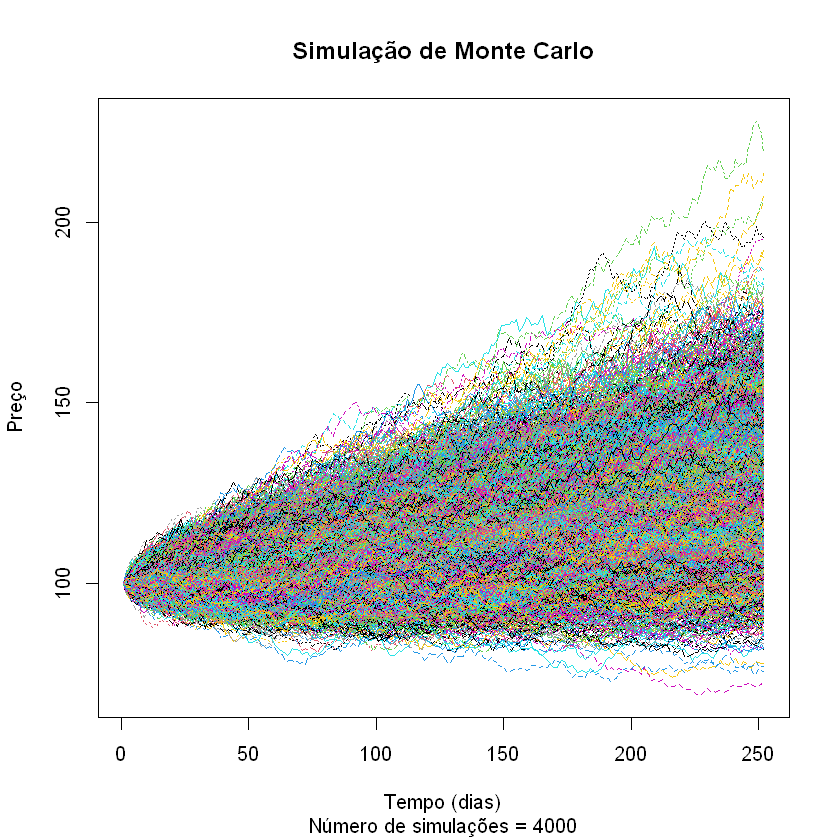

In [114]:
matplot(total_sim,
        main="Simulação de Monte Carlo",
        xlab="Tempo (dias)",ylab="Preço",
        col=1:n_sim, type = "l", sub = paste("Número de simulações =",n_sim))

In [115]:
#5% dos preços são menores que X e 95% são menores que Y
total_sim %>% quantile(probs = c(0.05,0.95)) %>% round(2) %>% print

    5%    95% 
 95.29 139.54 


In [116]:
p_5 <- qnorm(0.05)
p_1 <- qnorm(0.01)

In [117]:
#VaR Paramétrico diário
Ug <- (1+u)^(1/(length(periodo)-1))-1
sd_d <- sd/sqrt((length(periodo)-1))
VaR5 <- round((1-exp(p_5*sd_d+Ug))*100,3)
names(VaR5) <- "VaR diário em % com 5% chance"
VaR5
VaR1 <- round((1-exp(p_1*sd_d+Ug))*100,3)
names(VaR1) <- "VaR diário em % com 1% de chance"
VaR1

VaR diário em % com 5% chance 
                        1.369

VaR diário em % com 1% de chance 
                           1.964

In [118]:
#VaR não paramétrico diário
retorno_d <- diff(total_sim,1)/total_sim[1:(nrow(total_sim)-1),]
var5 <- -round(quantile(retorno_d*100, probs = c(0.05)),3)
names(var5) <- c("VaR 5% chance em %")
var5
var1 <- -round(quantile(retorno_d*100, probs = 0.01),3)
names(var1) <- "VaR 1% chance em %"
var1

VaR 5% chance em % 
             1.369

VaR 1% chance em % 
             1.978

In [119]:
#VaR Paramétrico Mensal
Ug_m <- (1+u)^(1/(12*(length(periodo)/252)))-1
sd_m <- sd/sqrt(12*length(periodo)/252)
VaR5_m <- round((1-exp(p_5*sd_m+Ug_m))*100,3)
names(VaR5_m) <- "VaR mensal em % com 5% chance"
VaR5_m
VaR1_m <- round((1-exp(p_1*sd_m+Ug_m))*100,3)
names(VaR1_m) <- "VaR mensal em % com 1% de chance"
VaR1_m

VaR mensal em % com 5% chance 
                        4.831

VaR mensal em % com 1% de chance 
                           7.429

In [120]:
#VaR Não-Paramétrico Mensal
retorno_m <- diff(total_sim,21)/total_sim[1:(nrow(total_sim)-21),]
var5_m <- -round(quantile(retorno_m*100, probs = c(0.05)),3)
names(var5_m) <- "VaR mensal 5% chance em %"
var1_m <- -round(quantile(retorno_m*100, probs = c(0.01)),3)
names(var1_m) <- "VaR mensal 1% chance em %"
var5_m
var1_m

VaR mensal 5% chance em % 
                    4.737

VaR mensal 1% chance em % 
                    7.309

In [121]:
estatisticas <- round(c(mean(total_sim[length(periodo),]), min(total_sim),
                  max(total_sim), 100*(quantile(total_sim[length(periodo),], probs = 0.5)/p_inicial)-100),2)
names(estatisticas) <- c("Média final", "Mínimo", "Máximo", "Retorno 50% em %")
print(estatisticas)

     Média final           Mínimo           Máximo Retorno 50% em % 
          125.81            69.10           228.03            24.41 


In [122]:
fora_curva <- round(c(((min(total_sim)/p_inicial)-1)*100,
                      ((max(total_sim)/p_inicial)-1)*100),3)
names(fora_curva) <- c("Perda Máxima %", "Ganho Máximo %")
print(fora_curva)

Perda Máxima % Ganho Máximo % 
       -30.898        128.027 


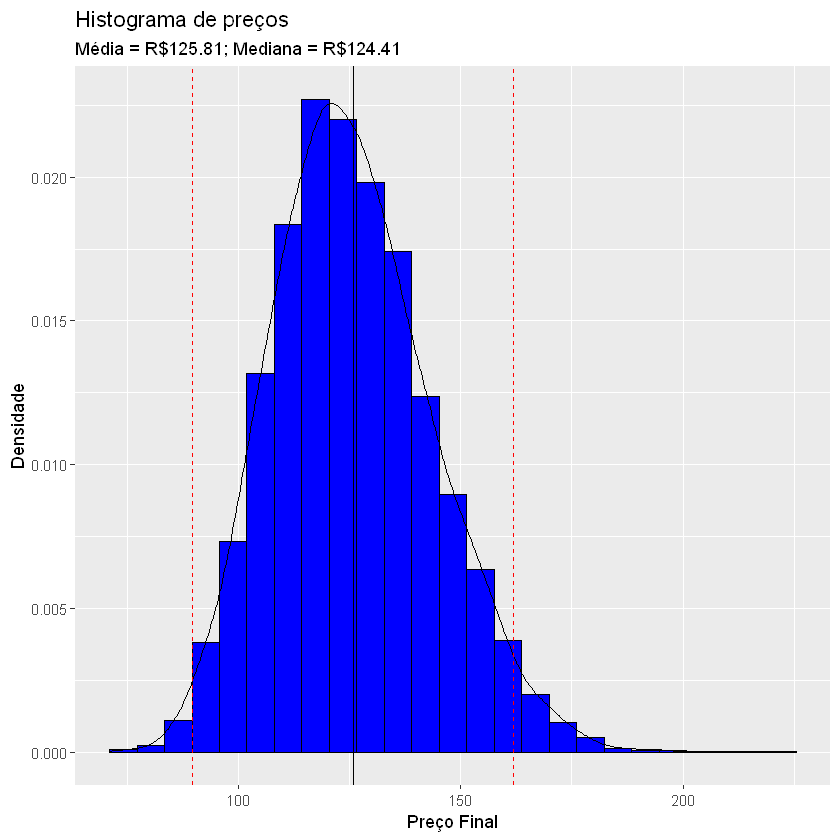

In [123]:
data <- data.frame(Final = total_sim[nrow(total_sim),])
ggplot(data, aes(x = Final, after_stat(density)))+
  geom_histogram(fill = "blue", col = "black", bins = 25)+
  geom_density()+
  geom_vline(xintercept = c(mean(data$Final),
                            mean(data$Final)+2*sd(data$Final),
                            mean(data$Final)-2*sd(data$Final)),
             col = c("black", "red", "red"), lty = c(1,2,2))+
  labs(x = "Preço Final", y = "Densidade", title = "Histograma de preços",
       subtitle = paste0("Média = R$",round(mean(data$Final),2),
                         "; Mediana = R$",round(median(data$Final),2)))

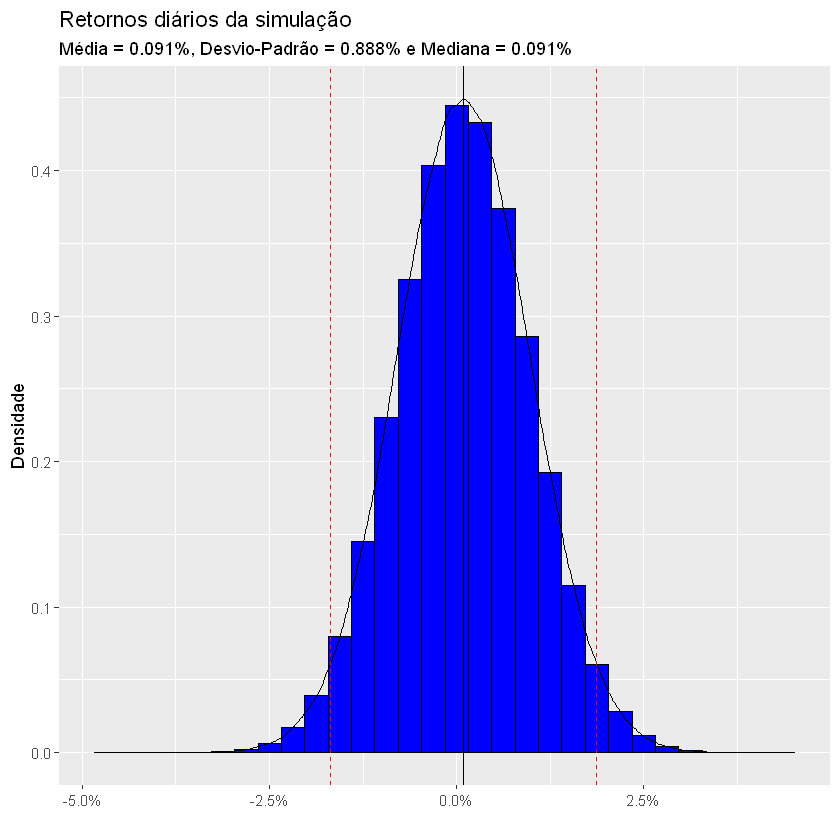

In [124]:
#Histograma de retornos diários
retorno <- retorno_d %>%
  data.frame() %>%
  gather(key = "Simulacoes", value = "value")
bandas <- c(mean(retorno$value),
            mean(retorno$value)+2*sd(retorno$value),
            mean(retorno$value)-2*sd(retorno$value))
retorno %>%
  ggplot(aes(x = value, after_stat(density)/100))+
  geom_histogram(fill = "blue", col = "black", bins = 30)+
  geom_density()+
  labs(x = "", y = "Densidade",
       title = "Retornos diários da simulação",
       subtitle = paste0("Média = ",round(mean(retorno$value)*100,3),"%, Desvio-Padrão = ",
                         round(sd(retorno$value)*100,3),
                         "% e Mediana = ",round(median(retorno$value)*100,3),"%"))+
  geom_vline(xintercept = bandas, lty = c(1,2,2), col = c("black", "red", "red"))+
  scale_x_continuous(labels = scales::percent)

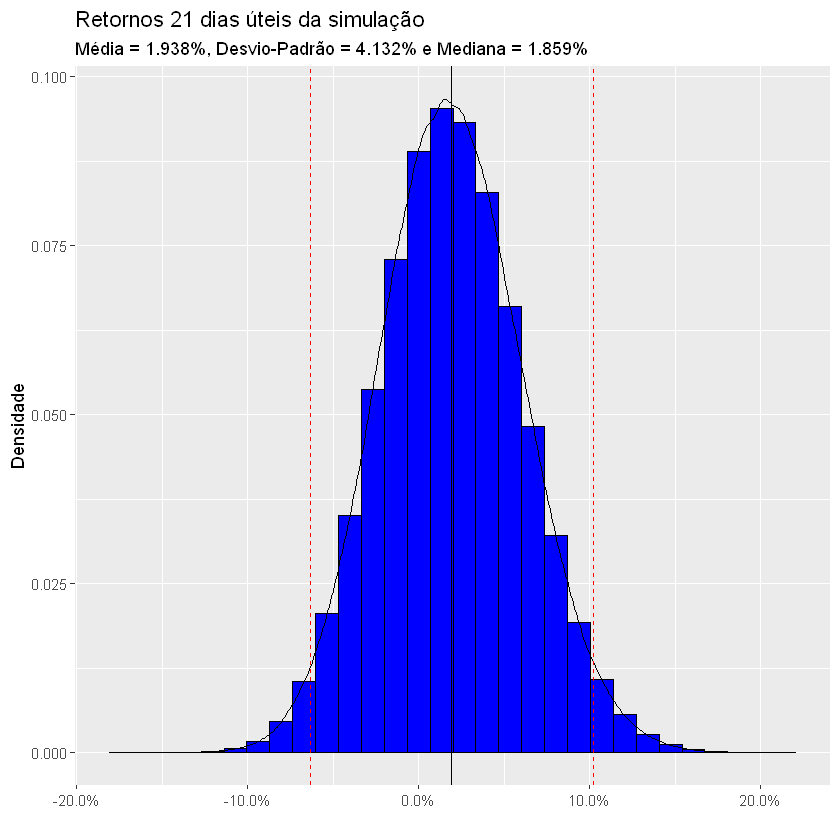

In [125]:
#Histograma de retornos mensais (21 dias úteis)
var_m <- retorno_m %>%
  data.frame() %>%
  gather(key = "Simulacoes", value = "value")
bandas_m<- c(mean(var_m$value),
            mean(var_m$value)+2*sd(var_m$value),
            mean(var_m$value)-2*sd(var_m$value))
var_m %>%
  ggplot(aes(x = value, after_stat(density)/100))+
  geom_histogram(fill = "blue", col = "black", bins = 30)+
  geom_density()+
  labs(x = "", y = "Densidade",
       title = "Retornos 21 dias úteis da simulação",
       subtitle = paste0("Média = ",round(mean(var_m$value)*100,3),"%, Desvio-Padrão = ",
                         round(sd(var_m$value)*100,3),
                         "% e Mediana = ", round(median(var_m$value)*100,3),"%"))+
  geom_vline(xintercept = bandas_m, lty = c(1,2,2), col = c("black", "red", "red"))+
  scale_x_continuous(labels = scales::percent)

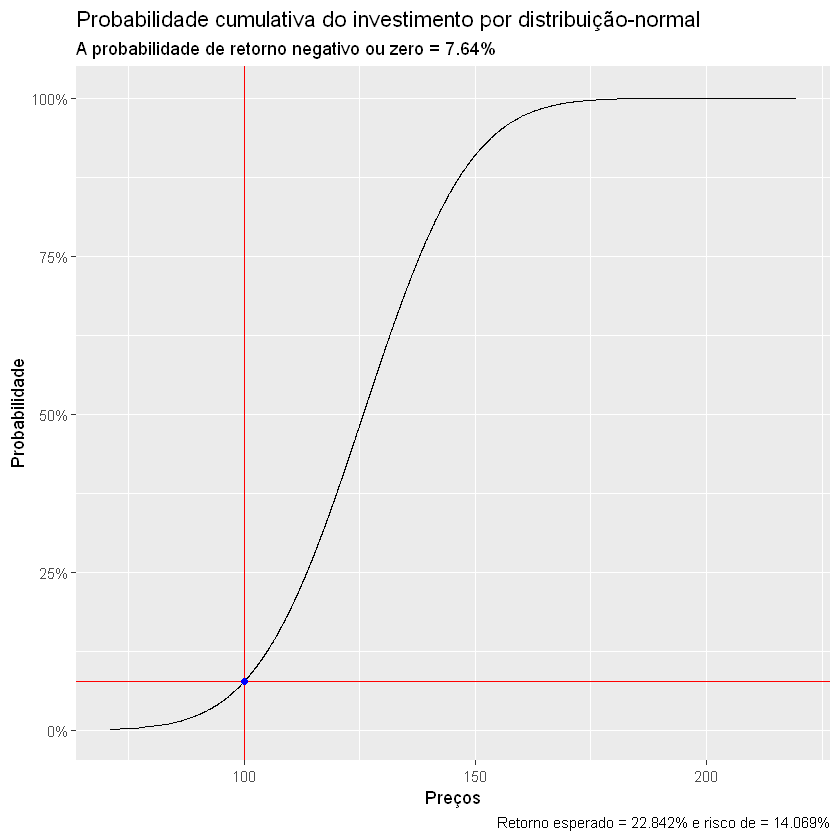

In [126]:
#Probabilidade pela distribuição normal
prob1 <- pnorm(data$Final, mean = mean(data$Final), sd = sd(data$Final))
prob1 <- data.frame(Preços = sort(data$Final), Probabilidade = sort(prob1))
pre <- pnorm(p_inicial, mean = mean(prob1$Preços), sd = sd(prob1$Preços))
ggplot(prob1, aes(x = Preços, y = Probabilidade))+
  geom_line()+
  geom_hline(yintercept = pre, col = "red")+
  geom_vline(xintercept = p_inicial, col = "red")+
  labs(title = "Probabilidade cumulativa do investimento por distribuição-normal",
       subtitle = paste0("A probabilidade de retorno negativo ou zero = ",round(pre*100,2),"%"),
      caption = paste0("Retorno esperado = ",round(u*100,3),"% e risco de = ",round(sd*100,3),"%"))+
  geom_point(aes(x = p_inicial, y = pre), col = "blue")+
  scale_y_continuous(labels = scales::percent)

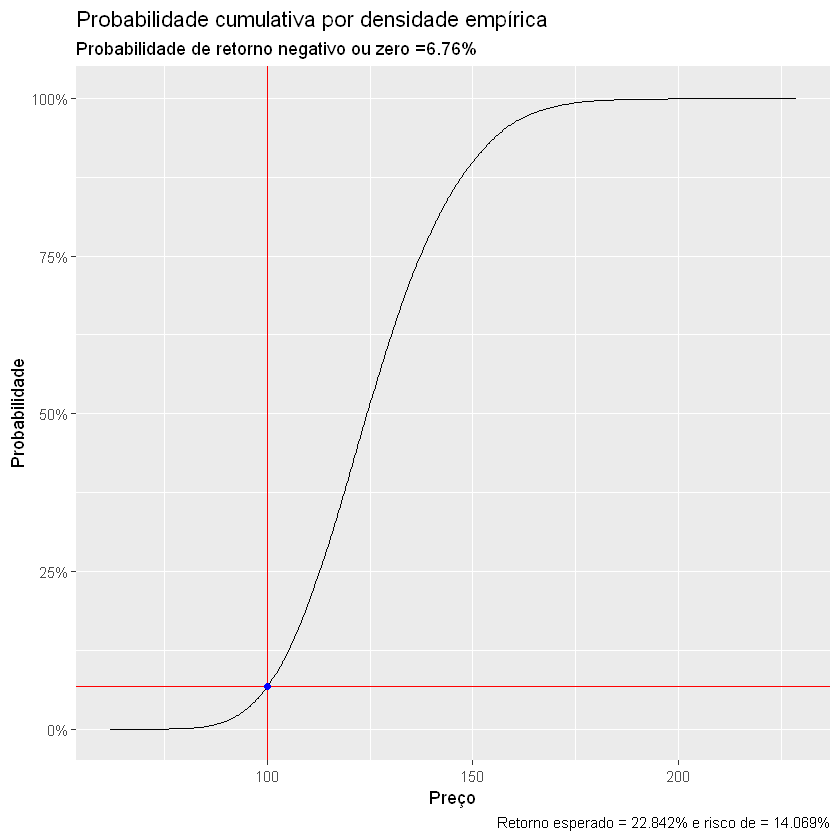

In [127]:
#Probabilidade pela soma cumulativa da densidade empírica
d <- density(data$Final)
d <- data.frame(x = d$x, prob = cumsum(d$y)/max(cumsum(d$y)))
proba <- round(d$prob[which(d$x >= p_inicial & d$x <= p_inicial*1.05)]*100,2)
ggplot(d,aes(x = x, y = prob))+
  geom_line()+
  geom_hline(yintercept = first(d$prob[which(d$x >= p_inicial & d$x <= p_inicial*1.05)]), col = "red")+
  geom_vline(xintercept = p_inicial, col = "red")+
  geom_point(aes(x = p_inicial,
                 y = first(prob[which(x >= p_inicial & x <= p_inicial*1.05)])),
             col = "blue")+
  labs(subtitle = paste0("Probabilidade de retorno negativo ou zero =",
                         first(proba),"%"),
       x = "Preço", y = "Probabilidade", title = "Probabilidade cumulativa por densidade empírica",
      caption = paste0("Retorno esperado = ",round(u*100,3),"% e risco de = ",round(sd*100,3),"%"))+
  scale_y_continuous(labels = scales::percent)